In [4]:
# Imports
import pandas as pd
import numpy as np

In [5]:
# Read in data
raw_data = pd.read_csv("immo_data.csv")

In [133]:
# Preprocessing
pd.set_option('display.max_rows', None, 'display.max_columns', None) # print everything
data = raw_data[raw_data["regio1"]=="Bayern"] # Reduce df to Bayern
#data["regio2"].unique()
#data.columns
data = data[data["regio2"] == "München"]# | np.array(data["regio2"] == "München_Kreis")] # Reduce df to München or Kreis München

In [134]:
data.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
23,Bayern,180.0,central_heating,ONE_YEAR_FREE,NaN,False,False,18,4.47,10.0,2030.0,1871.0,113626688,NaN,district_heating,True,Bayern,True,1.0,1850.0,NaN,81.0,München,well_kept,NaN,no,no_information,NaN,False,8,apartment,80331,2.0,48.4,4.0,4.0,2,False,4,München,Altstadt,Die Wohnung (OHNE Balkon !!) liegt im 4. OG (O...,- Eichenparkettboden im Wohn-EZ u. im Schlafzi...,NaN,NO_INFORMATION,NaN,NaN,NaN,Oct19
28,Bayern,0.0,NaN,ONE_YEAR_FREE,NaN,False,True,25,7.53,40.0,2400.0,1956.0,111398027,1.0,gas,False,Bayern,False,2.0,2400.0,3,61.0,München,NaN,NaN,NaN,Burgunderstra&szlig;e,Burgunderstraße,True,9,NaN,80804,3.0,210.6,1.0,NaN,3,False,3,München,Schwabing_West,"Highlights:\n\n * alle Wände der Wohnräume, Kü...",Waschmaschine in der Wohnung\nFlachbildfernseh...,NaN,NaN,NaN,NaN,NaN,May19
32,Bayern,0.0,NaN,ONE_YEAR_FREE,NaN,False,True,29,6.08,40.0,2780.0,2016.0,112411856,NaN,district_heating,False,Bayern,False,9.0,2780.0,51,100.0,München,NaN,NaN,NaN,Am Oberwiesenfeld,Am_Oberwiesenfeld,True,9,NaN,80809,3.0,44.8,5.0,NaN,3,False,4,München,Milbertshofen,Bitte beachten Sie: Die Wohnung ist komplett m...,Waschmaschine in der Wohnung\nFlachbildfernseh...,NaN,NaN,NaN,NaN,NaN,Feb20
118,Bayern,NaN,NaN,NaN,NaN,True,True,14,7.32,NaN,1390.0,2018.0,108881424,1.0,district_heating,False,Bayern,False,9.0,1390.0,NaN,33.0,München,NaN,NaN,no,no_information,NaN,True,7,NaN,80807,1.0,81.0,3.0,NaN,1,False,1,München,Schwabing,Möbliertes Wohnen auf Zeit:\nModernes Apartmen...,Bettwäsche\nCouch\nDusche\nEinbauküche\nFranzö...,NaN,C,NaN,NaN,NaN,May19
161,Bayern,290.0,district_heating,ONE_YEAR_FREE,NaN,False,True,16,5.72,10.0,NaN,1959.0,113593417,1.0,NaN,True,Bayern,True,2.0,2250.0,4,82.0,München,first_time_use_after_refurbishment,luxury,NaN,Corneliusstra&szlig;e,Corneliusstraße,True,9,apartment,80469,2.0,76.7,3.0,6.0,2,True,4,München,Ludwigsvorstadt_Isarvorstadt,"Das Mehrfamilienhaus ""COR 4"" (60er Jahre Kult)...",Eichenparkett m. weißen Sockelleisten\nFußbode...,NaN,NO_INFORMATION,2019.0,NaN,NaN,Oct19


In [135]:
from sklearn.model_selection import train_test_split

# Which predictors should the model use?
predictors = ["heatingType","balcony", "yearConstructed", "noParkSpaces", "hasKitchen", "cellar", "livingSpace","condition", "interiorQual", "floor", "regio3", "noRooms"]

y = data.baseRent
X = data[predictors]

# Only use data where baseRent is smaller 1400€
y = y[data.baseRent<1400]
X = X[data.baseRent<1400]

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

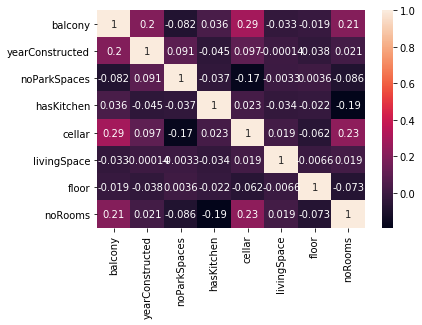

In [143]:
# correlation matrix
import seaborn as sns

import matplotlib.pyplot as plt

correlation_mat = X.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

In [145]:
# Number of NaNs in every column
print(X[predictors].shape)
print(X[predictors].isnull().sum())

(1837, 12)
heatingType         365
balcony               0
yearConstructed     391
noParkSpaces       1006
hasKitchen            0
cellar                0
livingSpace           0
condition           500
interiorQual        641
floor               234
regio3                0
noRooms               0
dtype: int64


In [144]:
### Pipelines

# Deciding how to impute missing values:
# heatingType, firingTypes, condition, interiorQual -> most frequent
# yearConstructed, floor -> median
# noParkSpaces -> constant (0)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Alternative models
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.svm import LinearSVR

#constant imputer
constant_imp = SimpleImputer(strategy='constant',fill_value=0)

# median imputer
median_imp = SimpleImputer(strategy='median')

# most_frequent imputer
mostfrequent_imp = SimpleImputer(strategy='most_frequent')

# Build rest of pipeline for categorical variables
imp_categorical_transformer = Pipeline(steps=[
    ('imputer',mostfrequent_imp),
    ('encoder',OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('constant',constant_imp,["noParkSpaces"]),
        ('median',median_imp,["yearConstructed","floor"]),
        ('imp_categorical',imp_categorical_transformer,["heatingType","condition","interiorQual"]),
        ('categorical',OneHotEncoder(handle_unknown = 'ignore'),["regio3"])
    ],remainder='passthrough')

# Define model
model = RandomForestRegressor(n_estimators=250, random_state=0)
#model = Lasso(tol=1e-5)
#model = SVR()

pipe = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',model)
])

pipe.fit(X_train,y_train)

preds=pipe.predict(X_valid)
print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 133.94055329192545


In [132]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('constant',
                                 SimpleImputer(fill_value=0,
                                               strategy='constant'),
                                 ['noParkSpaces']),
                                ('median', SimpleImputer(strategy='median'),
                                 ['yearConstructed', 'floor']),
                                ('imp_categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['heatingType', 'condition', 'interiorQual']),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='ignore'),
                             

In [ ]:
# TODO: Encode categorical variables

In [57]:
# All categorical columns
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if 
                   set(X_train[col]) == set(X_valid[col])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be label encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be label encoded: ['heatingType', 'interiorQual']

Categorical columns that will be dropped from the dataset: ['condition', 'firingTypes']
